# Explore Concepts needed for Lighting Controller

In [99]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from IPython.display import Image as disp_Image
import colorsys

from display_helper import *

# from controller_helper import LightingController


ModuleNotFoundError: No module named 'digitalio'

In [94]:
class Model():
    """
    Class representing the sides and top of the model and their LEDs
    """
    def __init__(self):

        # Model Configuration (including some attributes for the simulated model)
        self.MODEL_INTERIOR_COLOR = 'rgb(128,128,128)'
        self.MODEL_OUTLINE_COLOR = 'rgb(0,0,0)'
        self.MODEL_CONFIG = {
            'Left': {
                # Real and Simulated: Arrangement of LEDs in this model (real or simulated)
                'leds': { 'rows': 5, 'cols': 6 },

                # Real: Mapping of the rows/cols and physical LED numbers on the LED Strip
                #       Set as a np.array of shape defined by leds => rows/cols above
                'led_ids': None,

                # Simulated: Dimensions of this component in the simulated model
                'bbox': (0,200, 200,400),
                },

            'Right': {
                # Arrangement of LEDs in this model (real or simulated)
                'leds': { 'rows': 5, 'cols': 6 },

                # Real: Mapping of the rows/cols and physical LED numbers on the LED Strip
                #       Set as a np.array of shape defined by leds => rows/cols above
                'led_ids': None,

                # Simulated: Dimensions of this component in the simulated model
                'bbox': (400,200, 600,400),
                },

            'Top': {
                # Arrangement of LEDs in this model (real or simulated)
                'leds': { 'rows': 2, 'cols': 3 },

                # Real: Mapping of the rows/cols and physical LED numbers on the LED Strip
                #       Set as a np.array of shape defined by leds => rows/cols above
                'led_ids': None,

                # Simulated: Dimensions of this component in the simulated model
                'bbox': (200,0, 400,200),
                }
        }

        # Model image
        self.model = None

        # Light Profiles
        # http://planetpixelemporium.com/tutorialpages/light.html
        self.LIGHT_PROFILE = {
            'Candle': { 'temp': 1900, 'rgb': (255, 147, 41) },
            '40W Tungsten': { 'temp': 2600, 'rgb': (255, 197, 143) },
            '100W Tungsten': { 'temp': 2850, 'rgb': (255, 214, 170) },
            'Halogen': { 'temp': 3200, 'rgb': (255, 241, 224) },
            'Carbon Arc': { 'temp': 5200, 'rgb': (255, 250, 244) },
            'High Noon Sun': { 'temp': 5400, 'rgb': (255, 255, 251) },
            'Direct Sunlight': { 'temp': 6000, 'rgb': (255, 255, 255) },
            'Overcast Sky': { 'temp': 7000, 'rgb': (201, 226, 255) },
            'Clear Blue Sky': { 'temp': 20000, 'rgb': (64, 156, 255) },
        }

        # Lighting Scenarios
        self.LIGHT_SCENARIO = {
            'Idle': None,
            'Standard': None,
            'Energy': None,
        }


    # ***********************************************
    # Methods to Simulate LED Behavior in the Model
    # ***********************************************
    def draw_model_sides_top(self):
        """
        Draw the main components of the model: sides, top
        """
        # Create background enclosure for the model
        self.model = Image.new( "RGB", (600,400), color=(10,10,10) )

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        for c in self.MODEL_CONFIG:
            model_draw.rectangle( self.MODEL_CONFIG[c]['bbox'], fill=self.MODEL_INTERIOR_COLOR, outline=self.MODEL_OUTLINE_COLOR )

    def draw_model_leds(self, led_colors:dict=None ):
        """
        Draw LEDs on the model based upon the configurations
        of the model
        @TODO: and the color for each LED
        """

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        # LEDs
        def _draw_led( xy, color='rgb(0,0,0)' ):
            """
            Draw one LED
            """
            LED_RADIUS = 5
            model_draw.ellipse( [ (xy[0]-LED_RADIUS,xy[1]-LED_RADIUS), (xy[0]+LED_RADIUS,xy[1]+LED_RADIUS)], fill=color, outline='rgb(0,0,0)' )

        for c in self.MODEL_CONFIG:

            # Determine the width and height of this component
            bbox = self.MODEL_CONFIG[c]['bbox']
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]

            # How many columns and rows of LEDs need to fit in this space
            n_cols = self.MODEL_CONFIG[c]['leds']['cols']
            n_rows = self.MODEL_CONFIG[c]['leds']['rows']

            # Determine the number of pixels per LED,
            # Adding 2 to the count so that LEDs will not be placed on an edge
            pix_per_col = w // (n_cols + 1)
            pix_per_row = h // (n_rows + 1)
            # print(c, bbox, w, h, n_cols, n_rows, pix_per_col, pix_per_row)

            # Draw the LEDs, starting with index 1 (to avoid an edge)
            for col in range(1,n_cols+1):
                for row in range(1, n_rows+1):

                    # Draw the LED using the specified color
                    if led_colors:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ), color=led_colors[c][row-1][col-1] )
                    else:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ) )

    def light_profile( self, source=None, temp=None ):
        """
        Set RGB color values based upon light source or light temperature

        Reference:
        * http://planetpixelemporium.com/tutorialpages/light.html
        """

        if (source is not None) and (temp is None):
            return { source: self.LIGHT_PROFILE[source] }

        if (source is None) and (temp is not None):
            for source in self.LIGHT_PROFILE:
                if temp == self.LIGHT_PROFILE[source]['temp']:
                    return { source: self.LIGHT_PROFILE[source] }

        return self.LIGHT_PROFILE


    # Create arrays representing the LED colors
    def map_led_brightness_to_rgb_string(self, brightness_array=None, c_profile='Direct Sunlight' ) -> np.ndarray:
        """
        Maps an array of scalar values in the range [0.0 to 1.0] and maps it to RGB value strings
        that are consistent with the specified or default color profile.
        The mapping is done by:
        1. Converting the color profile base RGB to the Hue, Lightness, Saturation (HLS) color scheme
        2. Then adjusting only the Lightness factor proportional to the brightness value in the input array
        3. Doing the above for each element in the array
        """

        # Create a numpy array of the same dimension as the input brightness array
        led_array = np.full_like( brightness_array, fill_value=np.nan )

        # Clip the values in the brightness array to the range [0.0 to 1.0]
        b_array = np.clip( brightness_array, 0.0, 1.0 )

        # Get the base HLS values that correspond to the color profile RGB
        h_prof, l_prof, s_prof = rgb_int_to_hls( np.array(self.LIGHT_PROFILE[c_profile]['rgb']) )

        # Helper function to map 
        def _helper_brightness_to_rgb_in_profile( b:float=None ) -> tuple:
            # Adjust the lightness factor based upon the brightness value [0.0 to 1.0]
            rgb = hls_to_rgb_int( (h_prof, b*l_prof, s_prof) )
            return rgb_to_string( rgb )

        # Perform a vector operation on all of the input array values
        led_array = np.vectorize( _helper_brightness_to_rgb_in_profile )( brightness_array )

        # Return the array of LED RGB string values
        return led_array        


    def led_test_pattern(self, pattern='Range', color_profile='Direct Sunlight' ) -> np.ndarray:
        """
        Create a test pattern of LED colors (dictionary of arrays containing RGB strings)

        * pattern:
            'Range': LEDs are set to display the full range of brightness for the specified color profile [default]
            'Random': Each LED set to a random brightness for the specified color profile
            'On': All LEDs set to maximum brightness for the specified color profile
            'Off': All LEDs set to the minimum brightness for the specified color profile

        * color_profile: Color Profile selection from self.LIGHT_PROFILE [default: 'Direct Sunlight']
        """
        led_colors = {}
        for c in self.MODEL_CONFIG:

            # Component LED config
            rows = self.MODEL_CONFIG[c]['leds']['rows']
            cols = self.MODEL_CONFIG[c]['leds']['cols']

            # Create an array of the proper dimensions for this component of the model
            b_arr = np.zeros( (rows,cols) )

            if pattern.lower() == 'random':
                # Set each LED to a random brightness
                b_arr = np.random.rand( rows, cols )

            elif pattern.lower() == 'on':
                # Set all LEDs to on / maximum brightness
                b_arr = np.ones( (rows,cols) )

            elif pattern.lower() == 'off':
                # Set all LEDs to off / minimium brightness
                # Note: No additional action required for this
                pass

            else:
                # Set the LEDs to show the full range of brightness from 0.0 to 1.0 
                for row_ix in range(rows):
                    for col_ix in range(cols):
                        b_arr[row_ix,col_ix] = float(row_ix)/(rows-1) if rows > 1 else 1.0
                        b_arr[row_ix,col_ix] *= float(col_ix)/(cols-1) if cols > 1 else 1.0

            # get the LED colors for this component based upon the specified Color Profile
            led_colors[c] = self.map_led_brightness_to_rgb_string( b_arr, color_profile )

        return led_colors


In [95]:
# Create arrays representing the LED colors
def fill_leds( rgb:tuple ):
    led_cols = {}
    for c in m.MODEL_CONFIG:
        led_cols[c] = np.full( (m.MODEL_CONFIG[c]['leds']['rows'], m.MODEL_CONFIG[c]['leds']['cols']), fill_value=rgb_to_string( rgb ) ) 

    return led_cols

In [96]:
m = Model()
# display( m.light_profile(source='Direct Sunlight') )
# display( m.light_profile(temp=5200) )
display( m.light_profile() )

{'Candle': {'temp': 1900, 'rgb': (255, 147, 41)},
 '40W Tungsten': {'temp': 2600, 'rgb': (255, 197, 143)},
 '100W Tungsten': {'temp': 2850, 'rgb': (255, 214, 170)},
 'Halogen': {'temp': 3200, 'rgb': (255, 241, 224)},
 'Carbon Arc': {'temp': 5200, 'rgb': (255, 250, 244)},
 'High Noon Sun': {'temp': 5400, 'rgb': (255, 255, 251)},
 'Direct Sunlight': {'temp': 6000, 'rgb': (255, 255, 255)},
 'Overcast Sky': {'temp': 7000, 'rgb': (201, 226, 255)},
 'Clear Blue Sky': {'temp': 20000, 'rgb': (64, 156, 255)}}


Color Profile: Candle


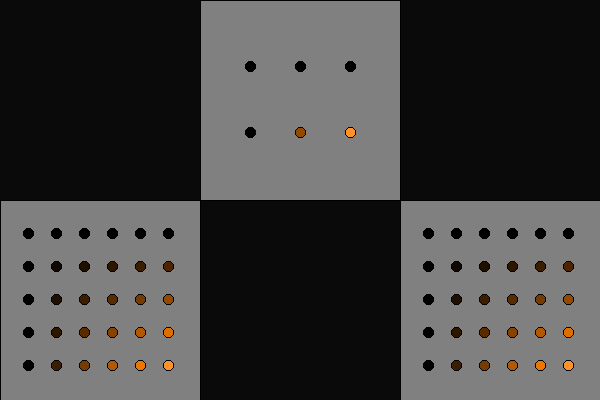


Color Profile: 40W Tungsten


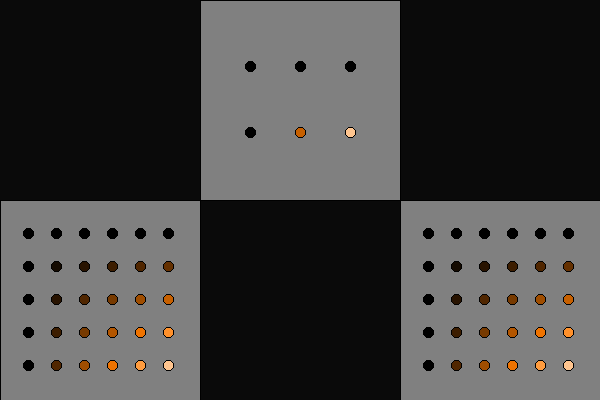


Color Profile: 100W Tungsten


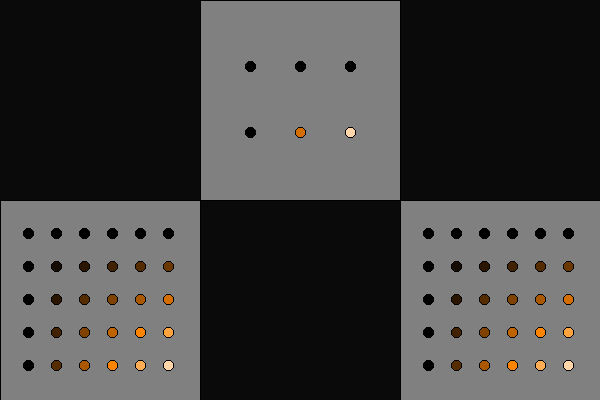


Color Profile: Halogen


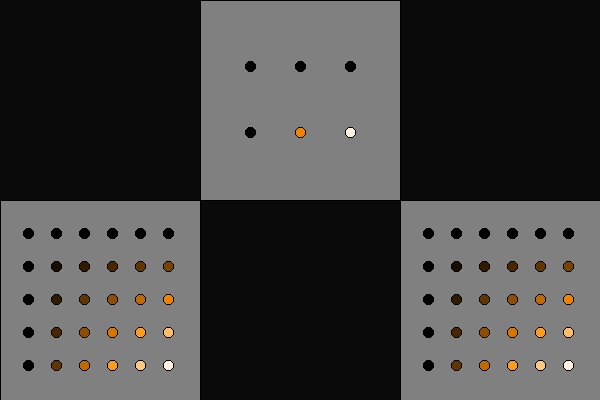


Color Profile: Carbon Arc


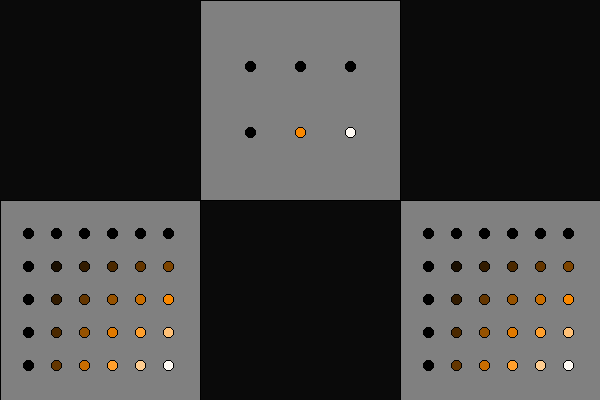


Color Profile: High Noon Sun


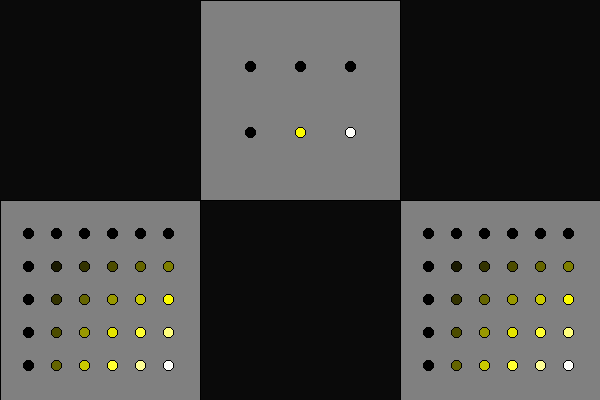


Color Profile: Direct Sunlight


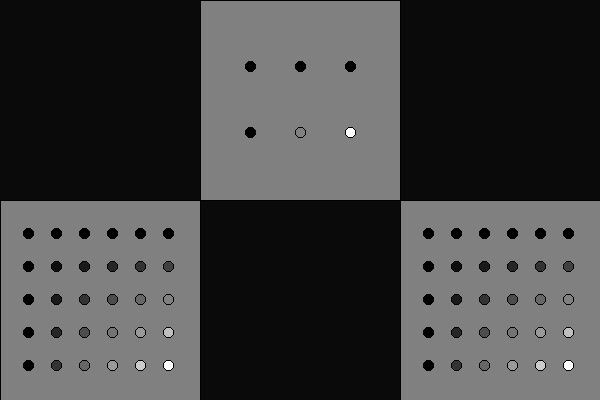


Color Profile: Overcast Sky


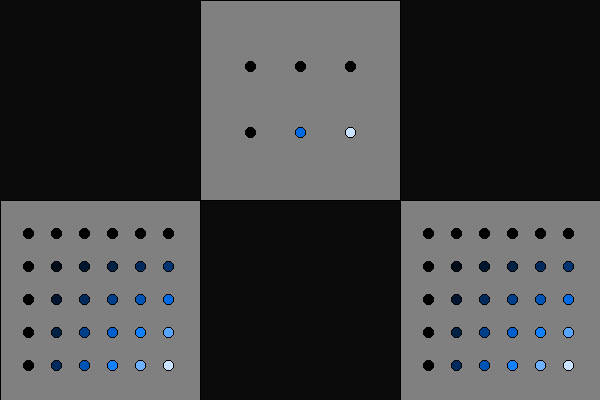


Color Profile: Clear Blue Sky


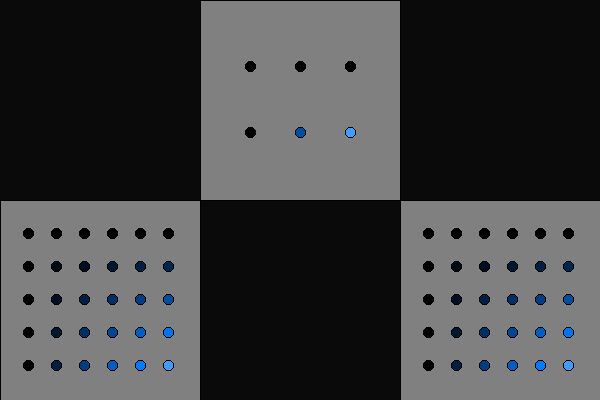

In [98]:
# Draw the model
m.draw_model_sides_top()

# Random LED brightness within color profile selection
for cp in m.LIGHT_PROFILE:
    print(f"\nColor Profile: {cp}")
    led_colors = m.led_test_pattern('Range', cp )    
    m.draw_model_leds( led_colors ) 
    display( m.model )


In [ ]:
# Create a model
m = Model()

# Draw the sides and top of the model
m.draw_model_sides_top()

images = []
for p in m2.LIGHT_PROFILE:
    rgb = m2.LIGHT_PROFILE[p]['rgb']
    hls = rgb_int_to_hls( rgb )
    hsv = rgb_int_to_hsv( rgb )
    print(f"Profile: {p} => rgb: {rgb} => hls: ({hls[0]:.3f},{hls[1]:.3f},{hls[2]:.3f}), hsv: ({hsv[0]:.3f},{hsv[1]:.3f},{hsv[2]:.3f})")

    lc = fill_leds( rgb )
    m.draw_model_leds( lc )
    images.append( m.model.copy() )

display_images( images, ms=500, loop=0 )